In [1]:
pip install scikit-learn xgboost matplotlib


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.8/150.0 MB 6.6 MB/s eta 0:00:23
    --------------------------------------- 3.1/150.0 MB 10.2 MB/s eta 0:00:15
   - -------------------------------------- 5.8/150.0 MB 11.0 MB/s eta 0:00:14
   -- ------------------------------------- 8.1/150.0 MB 11.2 MB/s eta 0:00:13
   -- ------------------------------------- 10.2/150.0 MB 11.4 MB/s eta 0:00:13
   --- ------------------------------------ 12.6/150.0 MB 11.1 MB/s eta 0:00:13
   --- ------------------------------------ 14.7/150.0 MB 11.1 MB/s eta 0:00:13
   ---- ----------------------------------- 17.0/150.0 MB 11.1 MB/s eta 0:00:13
   ----- ---------------------------------- 19.4/150.0 MB 11.1 MB/s eta 0:00:12
   ----- ---------------------------------- 21.5/150.0 MB 11.1 MB/s eta 0:00:12
   ------ --------------------------------- 23.9/150.0 M

In [5]:
from xgboost import XGBRegressor
import numpy as np
from sklearn.datasets import make_regression
from time import time

X, y = make_regression(n_samples=1_000_000, n_features=20, noise=0.1)
model = XGBRegressor(n_jobs=-1, tree_method="hist")  # Используем все потоки

start = time()
model.fit(X, y)
print("Time:", round(time() - start, 2), "seconds")


Time: 3.07 seconds


In [9]:
pip install xgboost --upgrade


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


Обработка 50000 строк...
Время обучения (CPU): 0.38 секунд

Обработка 100000 строк...
Время обучения (CPU): 0.49 секунд

Обработка 250000 строк...
Время обучения (CPU): 0.84 секунд

Обработка 500000 строк...
Время обучения (CPU): 1.46 секунд

Обработка 750000 строк...
Время обучения (CPU): 2.16 секунд

Обработка 1000000 строк...
Время обучения (CPU): 2.99 секунд

Обработка 50000 строк...
Время обучения (CUDA): 0.81 секунд

Обработка 100000 строк...
Время обучения (CUDA): 0.65 секунд

Обработка 250000 строк...
Время обучения (CUDA): 0.85 секунд

Обработка 500000 строк...
Время обучения (CUDA): 1.19 секунд

Обработка 750000 строк...
Время обучения (CUDA): 1.50 секунд

Обработка 1000000 строк...
Время обучения (CUDA): 1.83 секунд

✅ Результаты сохранены в xgboost_fit_benchmark_pc2_v2.csv
✅ Результаты сохранены в xgboost_fit_benchmark_pc2_v2.csv


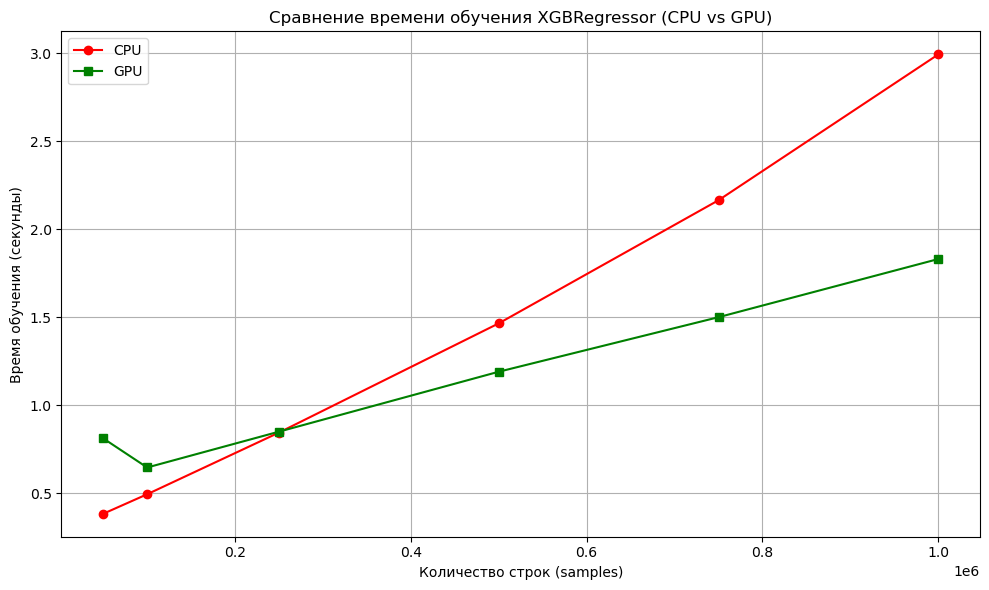

In [15]:
import numpy as np
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from time import time
import csv
from datetime import datetime
import platform
import subprocess

def get_gpu_name():
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=name', '--format=csv,noheader'],
                                capture_output=True, text=True)
        return result.stdout.strip()
    except Exception:
        return "GPU не обнаружен или nvidia-smi не установлен"

def measure_fit_time(n_samples_list, device='cpu', n_features=20):
    times = []

    for n in n_samples_list:
        print(f"Обработка {n} строк...")
        X, y = make_regression(n_samples=n, n_features=n_features, noise=0.1)

        model = XGBRegressor(
            n_jobs=-1,
            tree_method='hist',
            device=device,       # GPU или CPU
            verbosity=0
        )

        start = time()
        model.fit(X, y)
        duration = time() - start
        times.append((n, duration))
        print(f"Время обучения ({device.upper()}): {duration:.2f} секунд\n")

    return times

def export_to_csv(results, device="cpu", filename="xgboost_fit_benchmark_pc2_v2.csv"):
    hardware_info = get_gpu_name() if device == "cuda" else platform.processor()
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    with open(filename, mode='a', newline='', encoding='utf-8') as file:     
        writer = csv.writer(file)
        writer.writerow([f"# Test started: {timestamp}, Device: {hardware_info}, Method: {device.upper()}"])
        writer.writerow(["n_samples", "fit_time_seconds"])
        for n, t in results:
            writer.writerow([n, round(t, 4)])
        writer.writerow([])

    print(f"✅ Результаты сохранены в {filename}")

def plot_results(cpu_results, gpu_results):
    cpu_samples = [x[0] for x in cpu_results]
    cpu_times = [x[1] for x in cpu_results]
    gpu_times = [x[1] for x in gpu_results]

    plt.figure(figsize=(10, 6))
    plt.plot(cpu_samples, cpu_times, marker='o', label='CPU', color='red')
    plt.plot(cpu_samples, gpu_times, marker='s', label='GPU', color='green')
    plt.title('Сравнение времени обучения XGBRegressor (CPU vs GPU)')
    plt.xlabel('Количество строк (samples)')
    plt.ylabel('Время обучения (секунды)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Заданные объёмы данных
samples = [50_000, 100_000, 250_000, 500_000, 750_000, 1_000_000]

# Замеры
cpu_results = measure_fit_time(samples, device='cpu')
gpu_results = measure_fit_time(samples, device='cuda')

# Сохранение
export_to_csv(cpu_results, device='cpu')
export_to_csv(gpu_results, device='cuda')

# График
plot_results(cpu_results, gpu_results)
